# Writing a predictor from a third party library

Having a good model for Document Layout Analysis is crucial to extract text from PDFs or scanned images. Suppose you found a great model from a third party library that is not supported by **deep**doctection but you want to use it in a pipeline component of the Analyzer. 

This notebook shows you how to write a model wrapper for YOLO models supported by the ultralytics library. Ultralytics has an **AGPL-3.0 license**, therefore all the code is relased with an **AGPL-3.0 license** as well. The model was trained on the now very popular `Doclaynet` dataset.

If you want to see, how you can configurate **deep**doctection even further once you have such a fine graded layout detection model, we suggest to check the notebook: **Advanced_Configuration**. 

Kudos to [**dinath1233**](https://github.com/adinath1233) for providing the code for the YoloDetector!

Kudos to [**omoured**](https://huggingface.co/omoured) for training Yolo on Doclaynet!

We assume PyTorch and **deep**doctection with a basic setting to be installed, therefore `pip install deepdoctection` will suffice.

In [1]:
import deepdoctection as dd

/home/janis/Documents/Repos/deepdoctection_pt/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[1122 16:39.48 @file_utils.py:36]  INF  PyTorch version 2.1.2+cu121 available.
[1122 16:39.48 @file_utils.py:74]  INF  Disabling Tensorflow because USE_TORCH is set


In [2]:
!pip install ultralytics

## Adding the model wrapper for YOLO


In [2]:
from __future__ import annotations 

from typing import Mapping
from deepdoctection.utils.types import PixelValues, PathLikeOrStr
from deepdoctection.utils.settings import TypeOrStr
from deepdoctection.utils.file_utils import Requirement

from ultralytics import YOLO

def _yolo_to_detectresult(results, categories) -> list[dd.DetectionResult]:
    """
    Converts YOLO detection results into DetectionResult objects using inference speed as confidence.

    :param results: YOLO detection results
    :param categories: List of category names or LayoutType enums for YOLO classes.
    :return: A list of DetectionResult objects
    """

    all_results: list[dd.DetectionResult] = []

    categories_name = categories.get_categories(as_dict=True)

            
    # Use inference speed as the confidence score (e.g., using 'inference' time as a proxy)
    confidence = results.speed.get('inference', 0) / 100  # Normalize by 100 if you want a scale between 0-1
    
    # Loop through each detected box
    for i, box in enumerate(results.boxes):
        # Extract and normalize bounding box coordinates
        x1, y1, x2, y2 = box.xyxy.tolist()[0]
        
        # Assign class_id based on detection order or results.boxes.cls if available
        class_id = int(box.cls)+1  # Get class ID based on available keys
        class_name = categories_name.get(class_id, "Unknown") # Directly retrieve the class name from categories
        
        # Create a DetectionResult object with inferred confidence
        detection = dd.DetectionResult(
            box=[x1, y1, x2, y2],
            score=confidence,  # Set the normalized speed as confidence
            class_id=class_id,
            class_name=class_name
        )
        
        # Append the DetectionResult to the list
        all_results.append(detection)

    return all_results

def predict_yolo(np_img: PixelValues, 
                 model, 
                 conf_threshold: float, 
                 iou_threshold: float, 
                 categories: dd.ModelCategories) -> list[dd.DetectionResult]:
    """
    Run inference using the YOLO model.
    
    :param np_img: Input image as numpy array (BGR format)
    :param model: YOLO model instance
    :param conf_threshold: Confidence threshold for detections
    :param iou_threshold: Intersection-over-Union threshold for non-max suppression
    :param categories: List of category names or LayoutType enums for YOLO classes.
    :return: A list of detection results
    """
    # Run the model
    results = model(source=np_img, conf=conf_threshold, iou=iou_threshold)[0]
    
    # Convert results to DetectionResult format
    all_results = _yolo_to_detectresult(results, categories)
    
    return all_results
    
class YoloDetector(dd.ObjectDetector):
    """
    Document detector using YOLO engine for layout analysis.
    
    Model weights must be placed at `.cache/deepdoctection/weights/yolo/`.
    
    The detector predicts different categories of document elements such as text, tables, figures, headers, etc.
    """
    def __init__(self, 
                 conf_threshold: float, 
                 iou_threshold: float, 
                 model_weights: PathLikeOrStr, 
                 categories: Mapping[int, TypeOrStr]) -> None:
        """
        :param conf_threshold: Confidence threshold for YOLO detections.
        :param iou_threshold: IoU threshold for YOLO detections.
        :param model_weights: Path to the YOLO model weights file.
        :param categories: List of category names or LayoutType enums for YOLO classes.
        """
        self.name = "yolo_detector"
        self.model_id = self.get_model_id()
        self.conf_threshold = conf_threshold
        self.iou_threshold = iou_threshold

        # Load YOLO model with specified weights
        self.model = YOLO(model_weights)

        if categories is None:
            raise ValueError("A dictionary of category mappings must be provided.")
        self.categories =dd.ModelCategories(init_categories=categories)
        
    def predict(self, np_img: PixelValues) -> list[dd.DetectionResult]:
        """
        Perform inference on a document image using YOLOv10 and return detection results.
        
        :param np_img: Input image as numpy array (BGR format)
        :return: A list of DetectionResult objects.
        """
        return predict_yolo(np_img, self.model, self.conf_threshold, self.iou_threshold, self.categories)

    @classmethod
    def get_requirements(cls) -> list[Requirement]:
        # You could write a function get_ultralytics_requirement() that reminds you to install ultralytics which is necessary to run this
        # predictor. 
        return []

    def clone(self) -> YoloDetector:
        """
        Clone the current detector instance.
        """
        return self.__class__(conf_threshold=self.conf_threshold, 
                              iou_threshold=self.iou_threshold, 
                              model_weights=self.model.model_path,
                              categories = self.categories)

    def get_category_names(self) -> tuple[ObjectTypes, ...]:
        """
        Get the category names used by YOLO for document detection.
        """
        return self.categories.get_categories(as_dict=False)

## Adding the model to the `ModelCatalog`

Next, we need to register the model artifact. Registering the model will make it much easier to use the later with the Analyzer. We use the `yolov10x_best.pt` checkpoint from [here](https://huggingface.co/omoured/YOLOv10-Document-Layout-Analysis).

By the way, the source code for training this model can be found [here](https://github.com/moured/YOLOv10-Document-Layout-Analysis.git).

Save the model under `dd.get_weights_dir_path() / "yolo/yolov10x_best.pt"`

In [3]:
dd.ModelCatalog.register("yolo/yolov10x_best.pt", dd.ModelProfile(
    name="yolo/yolov10x_best.pt",
    description="YOLOv10 model for layout analysis",
    tp_model=False,
    size=[],
    categories={
        1: dd.LayoutType.CAPTION,
        2: dd.LayoutType.FOOTNOTE,
        3: dd.LayoutType.FORMULA,
        4: dd.LayoutType.LIST_ITEM,
        5: dd.LayoutType.PAGE_FOOTER,
        6: dd.LayoutType.PAGE_HEADER,
        7: dd.LayoutType.FIGURE,
        8: dd.LayoutType.SECTION_HEADER,
        9: dd.LayoutType.TABLE,
        10: dd.LayoutType.TEXT,
        11: dd.LayoutType.TITLE,
    },
    model_wrapper="YoloDetector"
))

## Modifying the factory class to build the Analyzer

The Analyzer is built with help of a `ServiceFactory`. This class is responsible to build a pipeline with a given config from the basic blocks, e.g. `Predictor`s, `PipelineComponent`s and many other things. If you want to avoid writing lots of code for a custom pipeline we suggest to only modify the static method of the `ServiceFactory`.

In our situation we want to add the `YoloDetector` once we select the newly registered model in the config parameter `PT.LAYOUT.WEIGHT`. Everything else must run in the same way. 

We therefore write small function `build_layout_detector` with our custom cude and replace its static method with the new function. (Yes, it looks hacky, but it is faster than writing a derived class...)

In [4]:
def build_layout_detector(config: AttrDict, mode: str = ""):
    # We want to return the YoloDetector if the profile in config.PT.LAYOUT.WEIGHTS points to a ModelProfile with a registered Yolo model.
    weights = getattr(config.PT, mode).WEIGHTS
    profile = dd.ModelCatalog.get_profile(weights)
    if profile.model_wrapper == "YoloDetector":
        model_weights = dd.ModelCatalog.get_full_path_weights(config.PT.LAYOUT.WEIGHTS)
        return YoloDetector(conf_threshold=0.2,
                            iou_threshold=0.8,
                            model_weights=model_weights,
                            categories=profile.categories)

    else:
        # the code for building the many other layout/table/table segmentation predictors is hidden behind _build_layout_detector.
        return dd.ServiceFactory._build_layout_detector(config, mode)
    
dd.ServiceFactory.build_layout_detector=build_layout_detector


## Running the Analyzer with the YoloDetector

Next we want to build the Analyzer with the new layout model. We change `PT.LAYOUT.WEIGHTS` to `yolo/yolov10x_best.pt` and switch everything else off for demo purposes.

One additional but not very obvious configuration step is crucial though: In order to show all layout sections the model is able to detect,
we need to list them in `TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES`. Otherwise, we will only display the default layout sections which are those defined by the `Publaynet` dataset: `text,title,list,table,figure`. 

In [20]:
analyzer = dd.get_dd_analyzer(config_overwrite=["PT.LAYOUT.WEIGHTS=yolo/yolov10x_best.pt",
                                                "USE_TABLE_SEGMENTATION=False",
                                                "USE_OCR=False",
                                                "TEXT_ORDERING.FLOATING_TEXT_BLOCK_CATEGORIES=['caption','footnote', 'formula','list_item','page_footer','page_header','figure','section_header','table','text','title']"])

[1122 17:40.41 @dd.py:148]  INF  Config: 
 {'DEVICE': device(type='cuda'),
 'LANGUAGE': None,
 'LAYOUT_LINK': {'CHILD_CATEGORIES': ['section_header'],
                 'PARENTAL_CATEGORIES': ['table', 'figure']},
 'LAYOUT_NMS_PAIRS': {'COMBINATIONS': None, 'PRIORITY': None, 'THRESHOLDS': None},
 'LIB': 'PT',
 'OCR': {'CONFIG': {'TESSERACT': 'dd/conf_tesseract.yaml'},
         'USE_DOCTR': False,
         'USE_TESSERACT': True,
         'USE_TEXTRACT': False,
         'WEIGHTS': {'DOCTR_RECOGNITION': {'PT': 'doctr/crnn_vgg16_bn/pt/crnn_vgg16_bn-9762b0b0.pt',
                                           'TF': 'doctr/crnn_vgg16_bn/tf/crnn_vgg16_bn-76b7f2c6.zip'},
                     'DOCTR_WORD': {'PT': 'doctr/db_resnet50/pt/db_resnet50-ac60cadc.pt',
                                    'TF': 'doctr/db_resnet50/tf/db_resnet50-adcafc63.zip'}}},
 'PDF_MINER': {'X_TOLERANCE': 3, 'Y_TOLERANCE': 3},
 'PT': {'CELL': {'FILTER': None,
                 'WEIGHTS': 'cell/d2_model_1849999_cell_inf_only

In [21]:
path="/path/to/dir/document.pdf"

df = analyzer.analyze(path=path)
df.reset_state()

In [22]:
dp = next(iter(df))

[1122 17:40.43 @doctectionpipe.py:84]  INF  Processing 2312.13560_0.pdf



0: 640x512 1 Page-header, 4 Section-headers, 13 Texts, 2 Titles, 10.7ms
Speed: 5.0ms preprocess, 10.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 512)


[1122 17:40.44 @context.py:133]  INF  ImageLayoutService total: 0.3841 sec.
[1122 17:40.44 @context.py:133]  INF  MatchingService total: 0.0001 sec.


In [23]:
img = dp.viz(interactive=False)

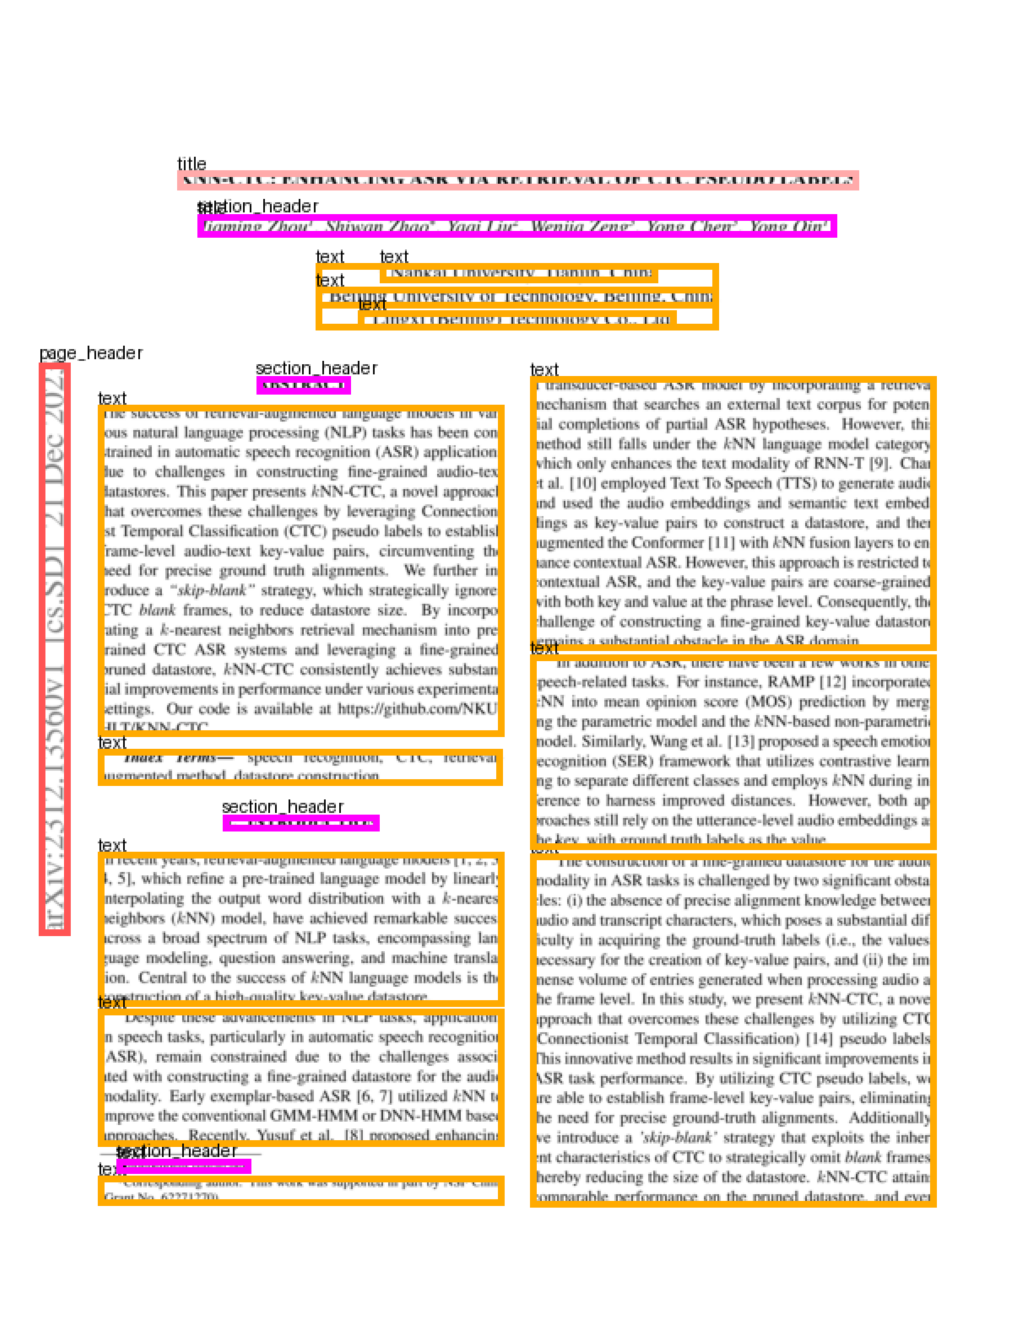

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(img)